In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm import tqdm
import sweetviz as sv
from pickle import dump
import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install sweetviz

Note: you may need to restart the kernel to use updated packages.


In [3]:
#loading the clean data
data=pd.read_csv('clean_data.csv',index_col=0)
data.head()

,id,artists,album,name,popularity,duration,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [4]:
data.isnull().sum()

id                  0
artists             0
album               0
name                0
popularity          0
duration            0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
genre               0
dtype: int64

In [5]:
data[data.duplicated()]

,id,artists,album,name,popularity,duration,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre


## Deleting the featrures which does not effect the train model with the domain knowledge

In [6]:
del data['id']
del data['album']
del data['genre']
del data['explicit']

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113549 entries, 0 to 113999
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   artists           113549 non-null  object 
 1   name              113549 non-null  object 
 2   popularity        113549 non-null  int64  
 3   duration          113549 non-null  int64  
 4   danceability      113549 non-null  float64
 5   energy            113549 non-null  float64
 6   key               113549 non-null  int64  
 7   loudness          113549 non-null  float64
 8   mode              113549 non-null  int64  
 9   speechiness       113549 non-null  float64
 10  acousticness      113549 non-null  float64
 11  instrumentalness  113549 non-null  float64
 12  liveness          113549 non-null  float64
 13  valence           113549 non-null  float64
 14  tempo             113549 non-null  float64
 15  time_signature    113549 non-null  int64  
dtypes: float64(9), int64

In [8]:
data.dtypes

artists              object
name                 object
popularity            int64
duration              int64
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
dtype: object

In [9]:
data.columns

Index(['artists', 'name', 'popularity', 'duration', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature'],
      dtype='object')

In [10]:
report=sv.analyze(data)

                                             |                                             | [  0%]   00:00 ->…

In [11]:
report.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### Scaling the data

In [13]:
# Normalizing the Numerical Columns so that max value  is 1 and min value  is 0
datatypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
normalization = data.select_dtypes(include=datatypes)

In [14]:
data.head(3)

,artists,name,popularity,duration,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,Gen Hoshino,Comedy,73,230666,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.358,0.715,87.917,4
1,Ben Woodward,Ghost - Acoustic,55,149610,0.420,0.166,1,-17.235,1,0.0763,0.9240,0.000006,0.101,0.267,77.489,4
2,Ingrid Michaelson;ZAYN,To Begin Again,57,210826,0.438,0.359,0,-9.734,1,0.0557,0.2100,0.000000,0.117,0.120,76.332,4


## Model Building 

In [15]:
# Plotted the scaled data with kmeans 
twss=[]
k=list(range(1,20))
for i in k:
    kM=KMeans(n_clusters=i)
    kM.fit_predict(normalization)
    twss.append(kM.inertia_)

Text(0.5, 0, 'No of clusters')

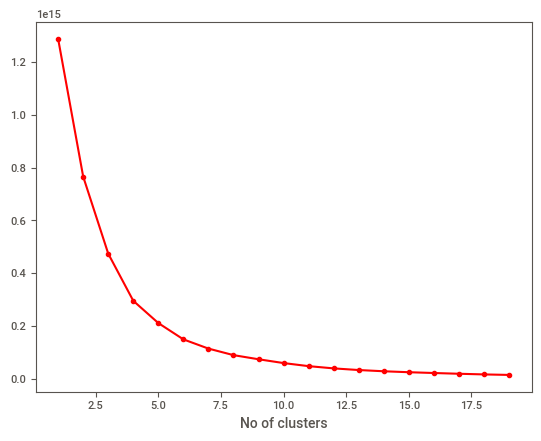

In [16]:
plt.plot(k,twss,'ro-');plt.xlabel('No of clusters')

In [17]:
#kmean clustering
kmeans = KMeans(n_clusters=6)
features = kmeans.fit_predict(normalization)
data['feature']=features

In [18]:
data.feature[:10]

0    5
1    1
2    5
3    5
4    5
5    5
6    5
7    5
8    5
9    5
Name: feature, dtype: int32

In [19]:
frnd=data[data.name=='Friends']
frnd.head(3)

,artists,name,popularity,duration,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,feature
1782,Jor'dan Armstrong,Friends,18,202277,0.742,0.6680,2,-3.871,0,0.0313,0.0152,0.000000,0.1560,0.806,97.009,4,5
4688,Morten Myklebust,Friends,26,168669,0.408,0.0835,3,-12.626,1,0.0422,0.9390,0.000006,0.1530,0.324,140.247,4,1
38560,levitation room,Friends,56,217666,0.639,0.5090,2,-10.354,1,0.0288,0.0020,0.000485,0.0834,0.739,100.157,4,5


In [20]:
data=data.rename({'name':'track_name'},axis=1)

## Songs Recommendation

In [21]:
class SpotifyRecommender():
    def __init__(self, rec_data):
        #our class should understand which data to work with
        self.rec_data_ = rec_data
    
    #function which returns recommendations, we can also choose the amount of songs to be recommended
    def get_recommendations(self, song_name, amount=20):
        distances = []
        #choosing the data for our song
        song = self.rec_data_[(self.rec_data_.track_name.str.lower() == song_name.lower())].head(1).values[0]
        #dropping the data with our song
        res_data = self.rec_data_[self.rec_data_.track_name.str.lower() != song_name.lower()]
        for r_song in (res_data.values):
            dist = 0
            for col in np.arange(len(res_data.columns)):
                #indeces of non-numerical columns
                if not col in [0,1]:
                    #calculating the manhettan distances for each numerical feature
                    dist = dist + np.absolute(float(song[col]) - float(r_song[col]))
            distances.append(dist)
        res_data['distance'] = distances
        #sorting our data to be ascending by 'distance' feature
        res_data = res_data.sort_values('distance')
        columns = ['track_name']
        return res_data[columns][:amount]

In [22]:
Recommender= SpotifyRecommender(data) 
Recommender

In [24]:
Recommender.get_recommendations('To Begin Again',10)

,track_name
17444,Chasing Pavements (Glee Cast Version)
112029,Hiphop Okulu
48207,Life's a Bitch (feat. AZ & Olu Dara)
49620,Among The Stars
28603,Freesol
29513,Freesol
97088,E Aí? - Ao Vivo
19706,I Hope
74452,Futuros Amantes
97885,Franguinho Na Panela - Ao Vivo


## Artists Recommendation

In [41]:
stev=data[data.artists=='ZAYN']
stev

,artists,track_name,popularity,duration,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,feature
20405,ZAYN,PILLOWTALK,78,202746,0.584,0.700,11,-4.275,1,0.0456,0.117,0.000000,0.0939,0.438,124.944,4,5
20801,ZAYN,Let Me,68,185373,0.460,0.566,9,-5.637,1,0.0502,0.239,0.000006,0.0967,0.189,168.408,4,5


In [26]:
class SpotifyRecommender_Artist():
    def __init__(self_1, rec_data_1):
        #our class should understand which data to work with
        self_1.rec_data__1 = rec_data_1
    
    
    #function which returns recommendations, we can also choose the amount of songs to be recommended
    def get_recommendations_artist(self_1, artist_name_1, amount=20):
        distances = []
        #choosing the data for our song
        artist = self_1.rec_data__1[(self_1.rec_data__1.artists.str.lower() == artist_name_1.lower())].head(1).values[0]
        #dropping the data with our song
        res_data_1 = self_1.rec_data__1[self_1.rec_data__1.artists.str.lower() != artist_name_1.lower()]
        for r_artist in (res_data_1.values):
            dist = 0
            for col in np.arange(len(res_data_1.columns)):
                #indeces of non-numerical columns
                if not col in [0,1]:
                    #calculating the manhettan distances for each numerical feature
                    dist = dist + np.absolute(float(artist[col]) - float(r_artist[col]))
            distances.append(dist)
        res_data_1['distance'] = distances
        #sorting our data to be ascending by 'distance' feature
        res_data_1 = res_data_1.sort_values('distance')
        columns = ['track_name']
        return res_data_1[columns][:amount]

In [27]:
artist=SpotifyRecommender_Artist(data)

In [40]:
artist.get_recommendations_artist('ZAYN',10)

,track_name
25700,Places
84434,Some Kind Of Wonderful - Remastered 1999
8931,Some Kind Of Wonderful - Remastered 1999
91151,Cold Heart - PNAU Remix
65840,Nonstop
56789,Pierre
4433,My Misty Mornings
97016,Sem Rede - Ao Vivo
43710,Eyes Off You (with Arlissa & Kiana Ledé)
23921,Eyes Off You (with Arlissa & Kiana Ledé)


In [29]:
artist.get_recommendations_artist('Ben Woodward',20)

,track_name
15822,ikigai
886,SOS - Acoustic Covers Versions
105660,Rare Rocks That Look Like David Letterman
45505,Unspoken
33988,Vypínám
26024,For the First Time in Forever (Reprise) - From...
21744,Oh Lawd
52564,Lesson One
85777,Gripin
108912,Lo Han Visto Con Otra - Remasterizado


## Deployment 

## Creating required pickle files for deployment purpose

In [30]:
 dump(data.to_dict(),open('data.pkl','wb'))

In [31]:
#saving tracks column in separate object
tracks=data[['track_name']]
tracks

,track_name
0,Comedy
1,Ghost - Acoustic
2,To Begin Again
3,Can't Help Falling In Love
4,Hold On
...,...
113995,Sleep My Little Boy
113996,Water Into Light
113997,Miss Perfumado
113998,Friends


In [32]:
#saving artists column in separate object
artist_name=data[['artists']]
artist_name

,artists
0,Gen Hoshino
1,Ben Woodward
2,Ingrid Michaelson;ZAYN
3,Kina Grannis
4,Chord Overstreet
...,...
113995,Rainy Lullaby
113996,Rainy Lullaby
113997,Cesária Evora
113998,Michael W. Smith


In [33]:
# dropping duplicates from the artists column n saving it another object 
artists=artist_name.drop_duplicates()
artists

,artists
0,Gen Hoshino
1,Ben Woodward
2,Ingrid Michaelson;ZAYN
3,Kina Grannis
4,Chord Overstreet
...,...
113965,Paz Interior
113969,Bethel Music;Molly Skaggs
113970,Cuencos Tibetanos Sonidos Relajantes
113989,Bryan & Katie Torwalt;Brock Human


In [34]:
song_data=tracks.copy()
song_data

,track_name
0,Comedy
1,Ghost - Acoustic
2,To Begin Again
3,Can't Help Falling In Love
4,Hold On
...,...
113995,Sleep My Little Boy
113996,Water Into Light
113997,Miss Perfumado
113998,Friends


In [35]:
artist_data=artists.copy()
artist_data.copy()

,artists
0,Gen Hoshino
1,Ben Woodward
2,Ingrid Michaelson;ZAYN
3,Kina Grannis
4,Chord Overstreet
...,...
113965,Paz Interior
113969,Bethel Music;Molly Skaggs
113970,Cuencos Tibetanos Sonidos Relajantes
113989,Bryan & Katie Torwalt;Brock Human


In [36]:
song_data.rename(columns={'track_name':'name'},inplace=True)
artist_data.rename(columns={'artists':'name'},inplace=True)

In [37]:
all_names=pd.concat([song_data,artist_data])
all_names

,name
0,Comedy
1,Ghost - Acoustic
2,To Begin Again
3,Can't Help Falling In Love
4,Hold On
...,...
113965,Paz Interior
113969,Bethel Music;Molly Skaggs
113970,Cuencos Tibetanos Sonidos Relajantes
113989,Bryan & Katie Torwalt;Brock Human


In [38]:
dump(all_names.to_dict(),open('names.pkl','wb'))
dump(tracks.to_dict(),open('song_names.pkl','wb'))
dump(artists.to_dict(),open('artist_name.pkl','wb'))

------------------------------------------------THE END-------------------------------------------------------------------